# Basic Setup

In [1]:
import os, sys
sys.path.append(os.getcwd()+'...')

from element_operation import *
import numpy as np

In [3]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import numpy.linalg

from quadrilateral_element import *
import quadrilateral_element
from element_operations import poisson
from utils import *

# Space Discretization

In [2]:
class scalar_wave(element_operation):
    def __init__(self, c, f):
        self.c = c  # Wave speed
        self.f = f  # Source term (function of x and t)

    def get_element_arrays(self, element):
        num_dofs = element.get_num_dofs()
        ke = np.zeros((num_dofs, num_dofs))  # Stiffness matrix (c²∇u)
        me = np.zeros((num_dofs, num_dofs))  # Mass matrix (ü term)
        fe = np.zeros(num_dofs)             # Force vector

        gauss_points, gauss_weights = element.get_quadrature()

        for q in range(len(gauss_points)):
            xi = gauss_points[q]
            w = gauss_weights[q]
            J = element.get_dmap(xi, jacobian=True)


            # Get the value of the gradient of all basis at the quadrature point
            grad_phi = []
            
            for l in range(num_dofs):
                # Get the base function gradients (already with respect to physical coordinates)
                grad_phi.append(element.get_base_function_grad(l, gauss_points[q]))

            for i in range(num_dofs):
                for j in range(num_dofs):
                    # Stiffness matrix (c²∇ϕ_i · ∇ϕ_j)
                    ke[i, j] += (c**2)*( np.dot(grad_phi[i], grad_phi[j])) * J * w                    
                    # Mass matrix (ϕ_i ϕ_j)
                    phi_i = element.get_base_function_val(i, xi)
                    phi_j = element.get_base_function_val(j, xi)
                    me[i, j] += np.dot(phi_i, phi_j) * J * w

                # Source term (f(x,t) * ϕ_i)
                if self.f:
                    x_physical = element.get_map(xi)
                    fe[i] -= gauss_weights[q] * element.get_base_function_val(i, gauss_points[q]) * J
                    #print(self.f(x))

        return ke, me, fe

# Signal Source

In [4]:
def source_time(t):
    
    f0 = 1e6               # Central frequency (1 MHz)
    num_cycles = 2         # Number of cycles in the pulse
    T = num_cycles / f0    # Pulse duration (1e-6 seconds)
    amplitude = 1       # Peak force (N)
    
    # Hanning window (0 <= t <= T)
    hann = 0.5 * (1 - np.cos(2 * np.pi * t / T))
    
    # Sine wave ( 1 cycles within T)
    cos = np.cos(2 * np.Spi * f0 * t)
    
    return amplitude * hann * cos

# Problem Setup

In [35]:
if __name__ == "__main__":

	# Define the order of the polynomial interpolant
	poly_order = 1

    
	# Define the half width of the domain
	w = 2.

	# Create the mesh of a square
	coordinates = np.array([ (-w,-w), (w,-w), (w,w), (-w,w) ])  

	# Connectivity 
	connectivity = np.array([[0,1,2,3]])

	# Refine a few times
	for i in range(5):
		coordinates, connectivity = subdivide_mesh( coordinates, connectivity )

	# Construct an array of element obejects 
	elements = []

	for e in range(len( connectivity ) ):
		elements.append( quadrilateral_element.element( e, coordinates, connectivity, poly_order) )

	# Create an instance of the local to global map 
	# for the current mesh
	l2g = quadrilateral_element.local_to_global_map( poly_order, connectivity )

	# Print out 
	total_dofs =  l2g.get_total_dof()
	print ('Total dofs : %i ' % total_dofs  )

	# Initialize stiffness matrix and force vector
	K = np.zeros( (total_dofs, total_dofs ) )
	M = np.zeros( (total_dofs, total_dofs ) )
	F = np.zeros( total_dofs )

	# Implement  Initial Source Term
	frequency = 1e6  # Frequency in Hz
	duration = 1e-6  # Duration of the pulse in seconds
	amplitude = 1  # Amplitude of the ultrasound wave
	t = np.linspace(0, 5 * duration, 100)  # Example time array
	f = lambda x: amplitude*0.5*(1-np.cos(2*np.pi))*np.cos(2*np.pi*frequency*duration)
    
    # Speed of Sound
	c = 5000.0
    
    # Discretize Space and Signal
	wave_problem = scalar_wave(c, f)

	print('Assemble system of equations')

	# Assemble global systems
	assemble_global(l2g, wave_problem , elements, K, M, F )

	print('System of equations asembled')

1
4
16
64
256
Total dofs : 1089 
Assemble system of equations
5.804792642593384 0.03293156623840332
System of equations asembled


# Apply Boundary Conditions

In [ ]:
	# Find all degrees of freedom on boundary
	boundary_dofs = l2g.get_boundary_dofs()

	# Get the values of the boundary conditions
	boundary_vals = boundary_dofs*0

	# Apply boundary conditions
	apply_bc(boundary_dofs, boundary_vals, K, M, F )

# Time Integration: Newark-Beta Method

In [36]:
import os
import imageio
import matplotlib.pyplot as plt

# Define parameters
dt = 4e-6  # Time step
steps = 5000  # Number of time steps

# Constants for Newmark method
beta = 0.25  # Can be adjusted based on stability requirements
gamma = 0.5  # Commonly used value

# Initialize necessary arrays
total_dofs = 1089  # Number of degrees of freedom
a = np.zeros((total_dofs, steps + 1))  # Acceleration array, (1089, steps + 1)
v = np.zeros((total_dofs, steps + 1))  # Velocity array, (1089, steps + 1)
u = np.zeros((total_dofs, steps + 1))  # Displacement array, (1089, steps + 1)

# Initial acceleration based on the initial condition
a[:, 0] = np.linalg.solve(M, F)  # Initial acceleration: a = M⁻¹ (F)

# Create directory to save frames
save_dir = os.path.expanduser("~/Desktop/HKUST-PG/SEMESTER 1/CIVL5390/Project_Code/fem/Images")
os.makedirs(save_dir, exist_ok=True)
frame_files = []

# Save initial state (step 0)
fig = plt.figure(figsize=(10, 6))
plot_contour(coordinates, u[:, 0])
plot_quad_mesh(coordinates, connectivity)
plt.colorbar()
frame_path = os.path.join(save_dir, "frame_0000.png")
plt.savefig(frame_path, dpi=150, bbox_inches='tight')
plt.close()
frame_files.append(frame_path)

# Time integration loop
for n in range(steps):
    current_time = n * dt
    #F.fill(0)
    #F = source_time(current_time)  # Adjust based on your source
    
    # Time extrapolation
    u[:, n + 1] = u[:, n] + v[:, n] * dt + ((dt**2) / 2) * ((1 - 2 * beta) * a[:, n] + 2 * beta * a[:, n])
    v[:, n + 1] = v[:, n] + dt * ((1 - gamma) * a[:, n] + gamma * a[:, n + 1])
    a[:, n + 1] = np.linalg.solve(M, F - np.matmul(K, u[:, n + 1]))

    # Save frames at steps 10, 20, ..., 200
    if (n + 1) % 50 == 0:
        fig = plt.figure(figsize=(10, 6))
        plot_contour(coordinates, u[:, n + 1])
        plot_quad_mesh(coordinates, connectivity)
        plt.colorbar()
        frame_path = os.path.join(save_dir, f"frame_{(n+1):04d}.png")
        plt.savefig(frame_path, dpi=150, bbox_inches='tight')
        plt.close()
        frame_files.append(frame_path)

# Create GIF from saved frames
gif_path = os.path.join(save_dir, "wave_animation.gif")
with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
    for filename in frame_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved at: {gif_path}")

/var/folders/33/2fhl4y111nd01dslpmtnk_8h0000gn/T/ipykernel_20764/2869122311.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 6))


GIF saved at: /Users/tahayasin/Desktop/HKUST-PG/SEMESTER 1/CIVL5390/Project_Code/fem/Images/wave_animation.gif


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

# Visualization

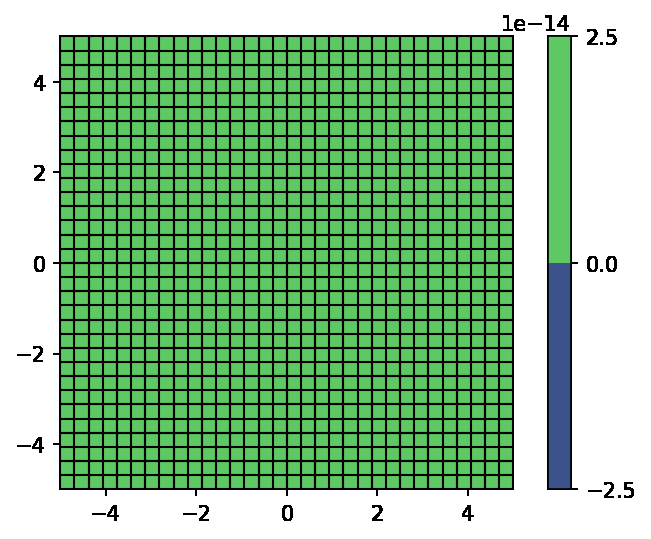

In [37]:
import os
from IPython.display import Image, display

# Path to the GIF file
gif_path = os.path.join(save_dir, "wave_animation.gif")

# Display the GIF
display(Image(filename=gif_path))

# Extra

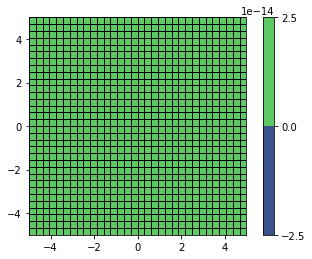

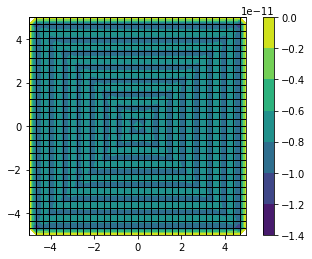

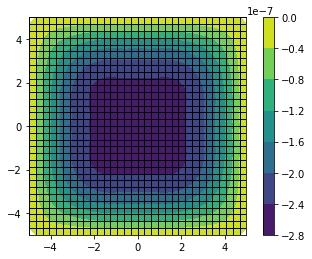

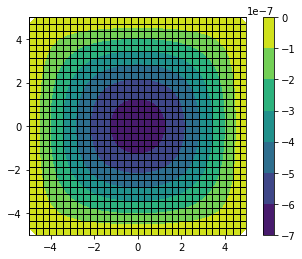

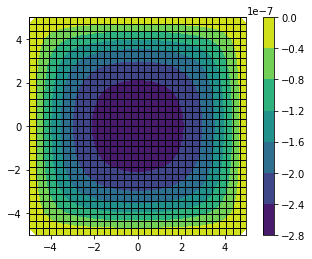

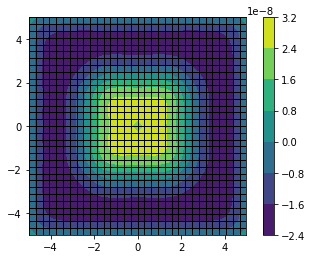

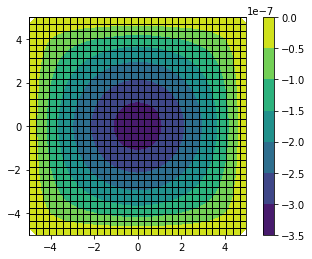

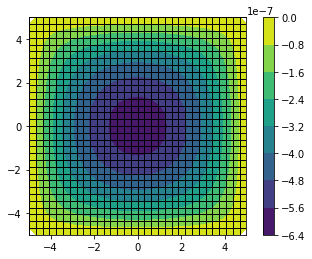

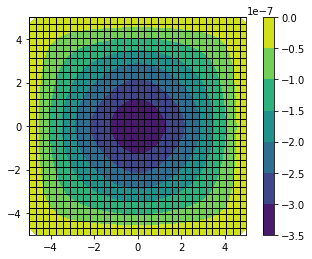

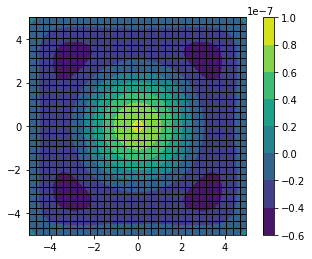

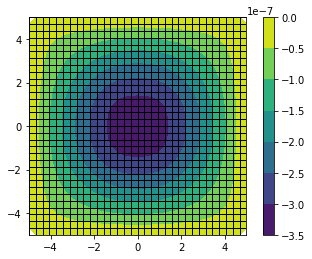

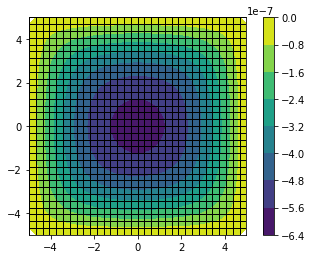

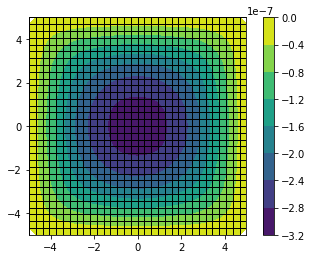

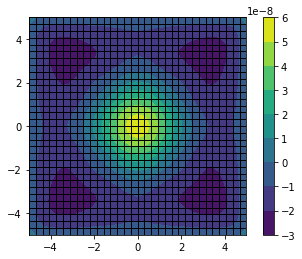

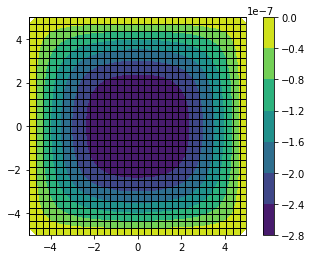

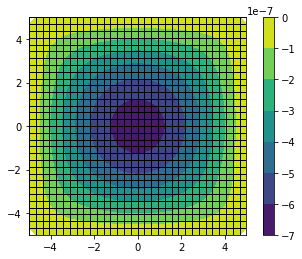

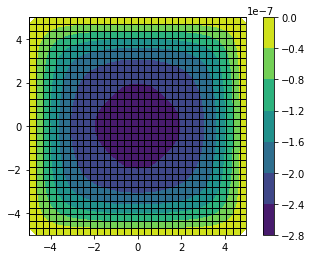

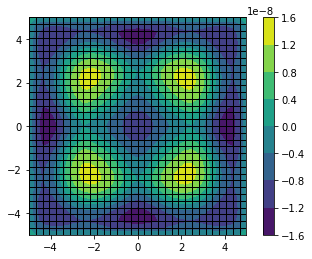

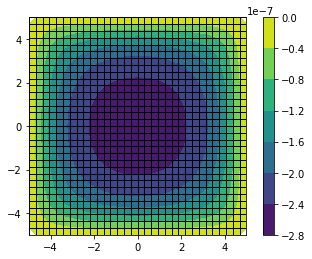

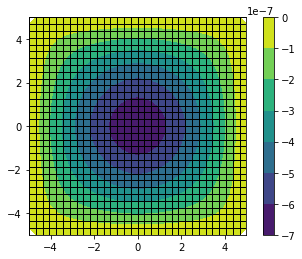

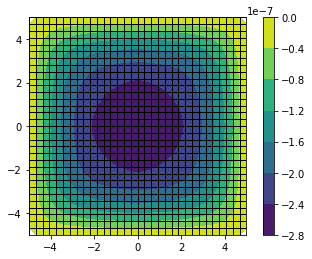

In [34]:
# Define parameters
dt = 4e-6  # Time step
steps = 5000  # Number of time steps

# Constants for Newmark method
beta = 1  # Can be adjusted based on stability requirements
gamma = 0.5  # Commonly used value

# Initialize necessary arrays
total_dofs = 1089  # Number of degrees of freedom
a = np.zeros((total_dofs, steps + 1))  # Acceleration array, (1089, steps + 1)
v = np.zeros((total_dofs, steps + 1))  # Velocity array, (1089, steps + 1)
u = np.zeros((total_dofs, steps + 1))  # Displacement array, (1089, steps + 1)

# Initial acceleration based on the initial condition
a[:, 0] = np.linalg.solve(M, F)  # Initial acceleration: a = M⁻¹ (F)

plot_contour( coordinates, u[:,0] )
plot_quad_mesh( coordinates, connectivity )
plt.colorbar()
plt.show()

# Time integration loop using Newmark method
for n in range(steps):
    
    #Extra: One Source at Top    
    #current_time = n * dt
    #F.fill(0)
    #F = source_time(current_time)
    
    
    # Time Extrapolation
    u[:, n + 1] = u[:, n] + v[:, n] * dt + ((dt**2) / 2) * ((1 - 2 * beta) * a[:, n] + 2 * beta * a[:, n])
    v[:, n + 1] = v[:, n] + dt * ((1 - gamma) * a[:, n] + gamma * a[:, n + 1])

    # Calculate the next acceleration
    a[:, n + 1] = np.linalg.solve(M, F - np.matmul(K, u[:, n + 1]))


    # Plot every N steps
    if n%250 == 0:
        #fig = plt.figure(figsize=(10, 6))
        plot_contour( coordinates, u[:,n+1] )
        plot_quad_mesh( coordinates, connectivity )
        plt.colorbar()
        plt.show()

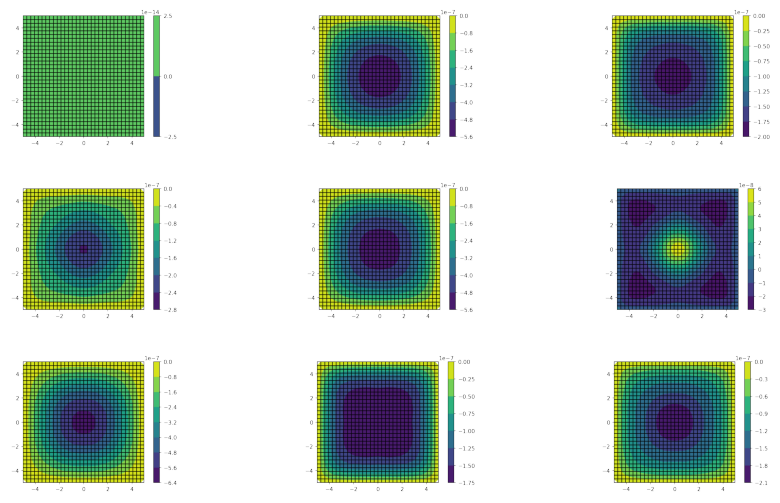

Summary plot saved at: /Users/tahayasin/Desktop/HKUST-PG/SEMESTER 1/CIVL5390/Project_Code/fem/Images/summary_result.png


In [42]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory where images are stored
# Assuming frame_files is a list of file paths for your images
# frame_files = [...]  # Your list of image file paths

# Select every 50th image
selected_frames = frame_files[::12]

# Determine the number of subplots needed
num_images = len(selected_frames)
cols = 3  # Number of columns for subplots
rows = (num_images // cols) + (num_images % cols > 0)  # Calculate rows needed

# Create a figure for the subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through the selected frames and add them to the subplots
for i, frame in enumerate(selected_frames):
    img = mpimg.imread(frame)
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Save the combined plot as an image
summary_result_path = os.path.join(save_dir, "summary_result.png")
plt.savefig(summary_result_path, bbox_inches='tight')
plt.show()

print(f"Summary plot saved at: {summary_result_path}")